In [1]:
from os import walk
import pandas as pd

import numpy as np
from PIL import Image
from sklearn import preprocessing
import cv2

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11582934957880020480
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6529366361
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1958635136258565212
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
with open("marks_train_small.txt", "r") as mt:
    marks_train = mt.readlines()

In [4]:
PIC_SIZE = (300, 300)

In [5]:
categories_train = {}
for line in marks_train:
    if line.startswith("#"):
        category = line.strip()[1:]
        paths = []
        marks = []
    else:
        path="train\\"+category+"\\"+line.split(";")[0]+".jpg"
        paths.append(path)
        markline = line.split(";")[1]
        markline = [int(i) for i in markline.split(",")]
        marks.append(markline)
    categories_train[category+"_path"] = paths
    categories_train[category+"_marks"] = marks

In [6]:
with open("marks_valid_small.txt", "r") as mv:
    marks_valid = mv.readlines()

In [7]:
categories_valid = {}
for line in marks_valid:
    if line.startswith("#"):
        category = line.strip()[1:]
        paths = []
        marks = []
    else:
        path="validation\\"+category+"\\"+line.split(";")[0]+".jpg"
        paths.append(path)
        markline = line.split(";")[1]
        markline = [int(i) for i in markline.split(",")]
        marks.append(markline)
    categories_valid[category+"_path"] = paths
    categories_valid[category+"_marks"] = marks

In [8]:
list(categories_train.keys())

['dress_path',
 'dress_marks',
 'hat_path',
 'hat_marks',
 'pants_path',
 'pants_marks',
 'shoes_path',
 'shoes_marks']

In [9]:
category="dress" #hat, shoes, pants, dress

In [10]:
mtpaths = categories_train[f"{category}_path"]
mtmarks = categories_train[f"{category}_marks"]

In [11]:
mvpaths = categories_valid[f"{category}_path"]
mvmarks = categories_valid[f"{category}_marks"]

In [12]:
labels_train=[]
for marks in mtmarks:
    x0, y0, deltaX, deltaY = marks
    x1 = x0 + deltaX
    y1 = y0 + deltaY
    labels_train.append([x0, y0, x1, y1])

In [13]:
labels_valid=[]
for marks in mvmarks:
    x0, y0, deltaX, deltaY = marks
    x1 = x0 + deltaX
    y1 = y0 + deltaY
    labels_valid.append([x0, y0, x1, y1])

In [14]:
rel_labels_train = []
for im, marks in zip(mtpaths, labels_train):
    height, width = cv2.imread(im, 0).shape
    x0, y0, x1, y1 = marks
    x0 /= width
    x1 /= width
    y0 /= height
    y1 /= height
    rel_labels_train.append([x0, y0, x1, y1])
rel_labels_train = np.array(rel_labels_train)
rel_labels_train.shape

(28, 4)

In [15]:
rel_labels_train.mean()

0.5022892821102528

In [16]:
rel_labels_valid = []
for im, marks in zip(mvpaths, labels_valid):
    height, width = cv2.imread(im, 0).shape
    x0, y0, x1, y1 = marks
    x0 /= width
    x1 /= width
    y0 /= height
    y1 /= height
    rel_labels_valid.append([x0, y0, x1, y1])
rel_labels_valid = np.array(rel_labels_valid)
rel_labels_valid.shape

(14, 4)

In [17]:
rel_labels_valid.shape, len(labels_valid)

((14, 4), 14)

In [18]:
#mvpaths[0], mvmarks[0]
img = mvpaths[2]
marks = mvmarks[2]
img, marks

('validation\\dress\\6ccb3f12-7087-4303-a522-3a76d3db8ce6.jpg',
 [89, 2, 220, 398])

In [19]:
arr = cv2.imread(img)
arr.shape

(400, 400, 3)

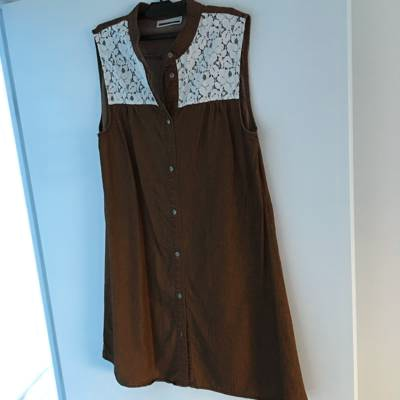

In [20]:
Image.fromarray(arr)

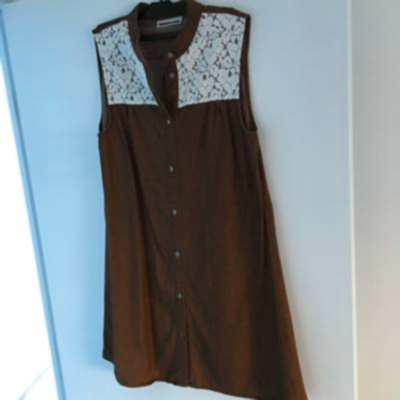

In [21]:
blur = cv2.GaussianBlur(arr,(3,3),0)
Image.fromarray(blur)

In [22]:
gen_images = [file for file in mtpaths]
bases = [cv2.imread(file) for file in gen_images]
color_blurs = [cv2.GaussianBlur(file,(3,3),0) for file in bases]

images = [cv2.resize(file, PIC_SIZE) for file in color_blurs]
train_dataset = np.array(images)
train_dataset.shape

(28, 300, 300, 3)

# for validation too

In [23]:
gen_images = [file for file in mvpaths]
bases = [cv2.imread(file) for file in gen_images]
color_blurs = [cv2.GaussianBlur(file,(3,3),0) for file in bases]

images = [cv2.resize(file, PIC_SIZE) for file in color_blurs]
valid_dataset = np.array(images)
valid_dataset.shape

(14, 300, 300, 3)

In [24]:
len(labels_train), len(labels_valid)

(28, 14)

In [25]:
train_dataset_norm = train_dataset / 255.
valid_dataset_norm = valid_dataset / 255.

# Bounding box part

In [26]:
from tensorflow.keras.layers import Dense, Conv2D

from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

input_tensor = Input(shape=(*PIC_SIZE, 3))
#layer = Conv2D(3, (3, 3), activation="relu")(input_tensor)
#layer = MaxPool2D(3, 3)(layer)

#layer = Conv2D(8, (3, 3), activation="relu")(input_tensor)
#layer = MaxPool2D(3, 3)(layer)

#layer = Conv2D(24, (3, 3), activation="relu")(layer)
#layer = MaxPool2D(3, 3)(layer)

#layer = Conv2D(3, (1, 1), activation="relu")(input_tensor)

vgg = VGG19(weights="imagenet", 
            include_top=False)(input_tensor)
vgg.trainable = False
            
flatten = Flatten()(vgg)
bboxHead = Dense(2014, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(bboxHead)
#bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
#bboxHead = Dropout(0.4)(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=input_tensor, outputs=bboxHead)

INIT_LR = 1e-4
opt = Adam(INIT_LR)
model.compile(loss="mae", optimizer=opt, metrics=['acc'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 2014)              83526622  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               257920    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132   

In [27]:
X_train = train_dataset_norm
y_train = np.array(rel_labels_train) #labels_train #rel_labels_train
X_test = valid_dataset_norm
y_test = np.array(rel_labels_valid) #labels_valid #rel_labels_valid

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28, 300, 300, 3), (28, 4), (14, 300, 300, 3), (14, 4))

In [29]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=25,
          #batch_size=32,
          verbose=2)

Epoch 1/25
1/1 - 16s - loss: 0.3802 - acc: 0.2857 - val_loss: 0.0784 - val_acc: 0.4286
Epoch 2/25
1/1 - 1s - loss: 0.0869 - acc: 0.6071 - val_loss: 0.0937 - val_acc: 0.4286
Epoch 3/25
1/1 - 1s - loss: 0.1058 - acc: 0.6071 - val_loss: 0.1024 - val_acc: 0.4286
Epoch 4/25
1/1 - 1s - loss: 0.1177 - acc: 0.6071 - val_loss: 0.0958 - val_acc: 0.4286
Epoch 5/25
1/1 - 1s - loss: 0.1069 - acc: 0.6071 - val_loss: 0.1057 - val_acc: 0.4286
Epoch 6/25
1/1 - 1s - loss: 0.1118 - acc: 0.6071 - val_loss: 0.0884 - val_acc: 0.4286
Epoch 7/25
1/1 - 1s - loss: 0.0989 - acc: 0.6071 - val_loss: 0.0806 - val_acc: 0.4286
Epoch 8/25
1/1 - 1s - loss: 0.0857 - acc: 0.6071 - val_loss: 0.0808 - val_acc: 0.4286
Epoch 9/25
1/1 - 1s - loss: 0.0808 - acc: 0.6071 - val_loss: 0.0738 - val_acc: 0.4286
Epoch 10/25
1/1 - 1s - loss: 0.0701 - acc: 0.6071 - val_loss: 0.0763 - val_acc: 0.4286
Epoch 11/25
1/1 - 1s - loss: 0.0773 - acc: 0.6071 - val_loss: 0.0837 - val_acc: 0.4286
Epoch 12/25
1/1 - 1s - loss: 0.0875 - acc: 0.6071 -

In [30]:
for N, im in enumerate(mtpaths):
    
    x0_rel, y0_rel, x1_rel, y1_rel = model.predict(np.array([X_train[N]]))[0]
    origin_array = cv2.imread(im)
    height, width, _ = origin_array.shape
    x0 = x0_rel * width
    y0 = y0_rel * height
    x1 = x1_rel * width
    y1 = y1_rel * height


    boxed = origin_array.copy()
    cv2.rectangle(img=boxed, 
              pt1=(int(x0), int(y0)),
              pt2=(int(x1), int(y1)), 
              color=(0, 255, 0),
              thickness=2)
    
    cv2.imwrite("output_train//{}//pic_{}.jpg".format(category, N), boxed)


In [31]:
for N, im in enumerate(mvpaths):
    
    x0_rel, y0_rel, x1_rel, y1_rel = model.predict(np.array([X_test[N]]))[0]
    origin_array = cv2.imread(im)
    height, width, _ = origin_array.shape
    x0 = x0_rel * width
    y0 = y0_rel * height
    x1 = x1_rel * width
    y1 = y1_rel * height


    boxed = origin_array.copy()
    cv2.rectangle(img=boxed, 
              pt1=(int(x0), int(y0)),
              pt2=(int(x1), int(y1)), 
              color=(0, 255, 0),
              thickness=2)
    
    cv2.imwrite("output_valid//{}//pic_{}.jpg".format(category, N), boxed)